In [29]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import imutils
from tqdm import tqdm, trange
import math
from copy import deepcopy


In [30]:
def dist(p1,p2):
    p1X = p1[0]
    p1Y = p1[1]
    p2X = p2[0]
    p2Y = p2[1]

    dX = (p2X - p1X) **2
    dY = (p2Y - p1Y) **2
    
    return dX+dY

In [31]:
filename = 'C:/ML_YGO/Data/full_db.txt'
with open(filename) as file:
    full_db = [line.rstrip() for line in file]

full_db_digit = []
full_db_name_ko = []

for item in full_db:
    data = item.split("\t")
    try:
        full_db_digit.append(data[1])
    except:
        full_db_digit.append(None)
    try:
        full_db_name_ko.append(data[3])
    except:
        full_db_name_ko.append(None)

In [32]:
path_pool = 'C:/ML_YGO/YGO_DB/'
filename = 'C:/ML_YGO/Data/used_db.txt'
with open(filename) as file:
    used_db = [line.rstrip() for line in file]
len(used_db)

used_dbs = []
for code in used_db:
    used_dbs.append( str(code) + ".jpg")

pool = used_dbs


1208-001.jpg


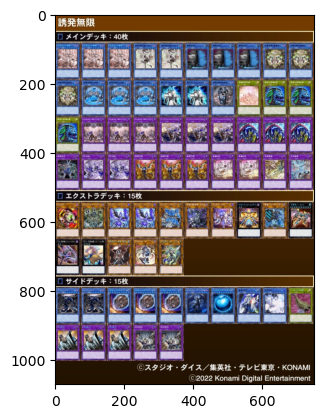

In [38]:
# Set fixed width
sample = "네가로기어 아제우스"
w1 = 1000
threshold = 0.75
deck_index = 0
######################
dup_tol = 10
sort_tol = 1000
sort_round = 10

# Choose Deck
deck_dir = 'C:/ML_YGO/Deck/'
deck_pool = os.listdir(deck_dir)

deck_ind = []
for deck in deck_pool:
    deck_txt = deck.split(".")[0]
    deck_txt = deck_txt.split("(")[0]
    deck_number = int(deck_txt.replace("-","0"))
    deck_ind.append(deck_number)

deck_sorted = [x for _,x in sorted(zip(deck_ind,deck_pool))]
deck = deck_sorted[deck_index]

print(deck)

preview = cv2.imread(f'{deck_dir}{deck}')
plt.imshow(preview, cmap='gray')

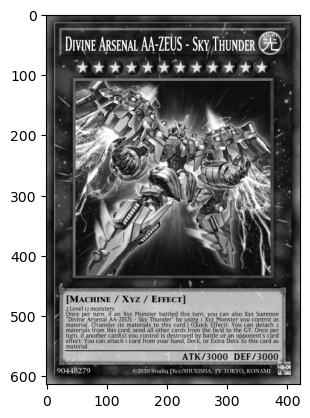

In [39]:
sample_index = full_db_name_ko.index(sample)
sample_digit = full_db_digit[sample_index]
sample_load = cv2.imread(f'C:/ML_YGO/YGO_DB/{sample_digit}.jpg', 0)
plt.imshow(sample_load, cmap='gray')

Ideal template image size is :  98 x 67


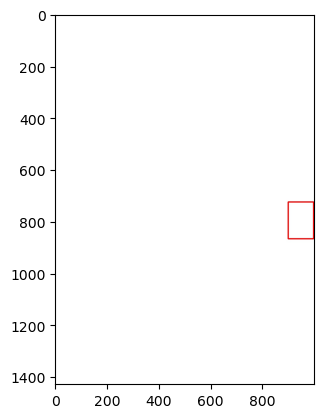

In [40]:
img_rgb = cv2.imread(f'{deck_dir}{deck}')  #Large image
img_rgb = imutils.resize(img_rgb, width = w1)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread(f'C:/ML_YGO/YGO_DB/{sample_digit}.jpg', 0)  #Small image (template)

deck_list_size = img_rgb.shape
width = deck_list_size[1]
height = deck_list_size[0]
blank_image = np.zeros((height,width,3), np.uint8)
blank_image[:,0:width//2] = (255,255,255)      # (B, G, R)
blank_image[:,width//2:width] = (255,255,255)

# cv2.imwrite('C:/ML_YGO/Result/blank.jpg', blank_image)
# plt.imshow(template, cmap='gray')

best_match = None

sc1 = int((w1 / 10) * 0.7 )
sc2 = int((w1 / 10) * 1.2 )
sc_dif = abs(sc2-sc1)+1

for scale in np.linspace(sc1, sc2, sc_dif):  #Pick scale based on your estimate of template to object in the image ratio

#Resize the input template image
    resized_template = imutils.resize(template, width = int(scale))    
    res = cv2.matchTemplate(img_gray, resized_template, cv2.TM_SQDIFF)
    min_val, _, min_loc, _ = cv2.minMaxLoc(res)  #Only care about minimum value and location as we are using TM_SQDIFF
    
    #Check if the min_val is the minimum compared to the value from other scales templates
    #If it is minimum then we got a better match compared to other scales
    #So save the value and location. 
    if best_match is None or min_val <= best_match[0]:
        ideal_scale=scale  #Save the ideal scale for printout. 
        h, w = resized_template.shape[::] #Get the size of the scaled template to draw the rectangle. 
        best_match = [min_val, min_loc, ideal_scale]
        
        
print("Ideal template image size is : ", int(ideal_scale), "x", int(     template.shape[1] *   ideal_scale / template.shape[0]))

#Save the image with a red box around the detected object in the large image. 
top_left = best_match[1]  #Change to max_loc for all except for TM_SQDIFF
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(blank_image, top_left, bottom_right, (255, 0,0), 3)
cv2.rectangle(img_rgb, top_left, bottom_right, (255, 25,255), 3)  #Red rectangle with thickness 2. 
cv2.imwrite('C:/ML_YGO/Result/auto_scale_scop.jpg', blank_image)
cv2.imwrite('C:/ML_YGO/Result/auto_scale_rgb.jpg', img_rgb)

w2 = int(ideal_scale)

test_plot = cv2.imread('C:/ML_YGO/Result/auto_scale_scop.jpg')
plt.imshow(test_plot, cmap='gray')


90448279
C:/ML_YGO/YGO_DB/90448279.jpg


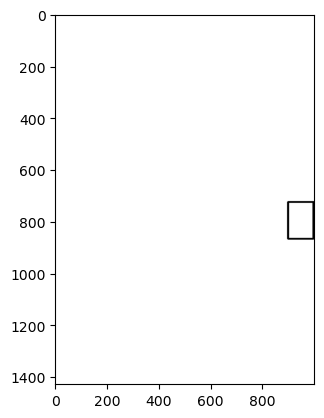

In [46]:
#TEST FOR Single Event

sample = "네가로기어 아제우스"
sample_index = full_db_name_ko.index(sample)
sample_digit = full_db_digit[sample_index]

card = sample_digit
print(card)

card_loc = []
card_pos = []

img_rgb = cv2.imread(f'{deck_dir}{deck}') #large image
img_rgb = imutils.resize(img_rgb, width = w1)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread(f'{path_pool}{card}.jpg', 0) #small image

deck_list_size = img_rgb.shape
width = deck_list_size[1]
height = deck_list_size[0]
blank_image = np.zeros((height,width,3), np.uint8)
blank_image[:,0:width//2] = (255,255,255)      # (B, G, R)
blank_image[:,width//2:width] = (255,255,255)

template = imutils.resize(template, width = w2)

h, w = template.shape[::]
res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)

min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

loc=np.where(res >= threshold)

num_loc = []
for pt in zip(*loc[::-1]):
    num_loc.append(pt)
    cv2.rectangle(blank_image, pt, (pt[0] + w, pt[1] + h), (0, 0, 0), 3)
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (255, 255, 255), 3)

card_loc.append(num_loc)

gamma = []
for i in range(len(loc[0])):
    u = loc[0][i]
    v = loc[1][i]
    temp = res[u][v]
    gamma.append(temp)
card_pos.append(gamma)

cv2.imwrite('C:/ML_YGO/Result/Single_Run.png', img_rgb)
cv2.imwrite('C:/ML_YGO/Result/Single_Scope.jpg', blank_image)

print(f'{path_pool}{card}.jpg')
test_plot = cv2.imread('C:/ML_YGO/Result/Single_Scope.jpg')
plt.imshow(test_plot, cmap='gray')

In [47]:
card_loc = []
card_pos = []

img_rgb = cv2.imread(f'{deck_dir}{deck}') #large image
img_rgb = imutils.resize(img_rgb, width = w1)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

for card in tqdm(pool):
    template = cv2.imread(f'{path_pool}{card}', 0) #small image
    template = imutils.resize(template, width = w2)

    h, w = template.shape[::]
    res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    loc=np.where(res >= threshold)

    num_loc = []
    for pt in zip(*loc[::-1]):
        num_loc.append(pt)
        cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (255, 255, 255), 1)

    card_loc.append(num_loc)

    gamma = []
    for i in range(len(loc[0])):
        u = loc[0][i]
        v = loc[1][i]
        temp = res[u][v]
        gamma.append(temp)
    
    card_pos.append(gamma)

cv2.imwrite('C:/ML_YGO/Result/Multi_Run.png', img_rgb)

print(len(card_loc))

100%|██████████| 1498/1498 [01:01<00:00, 24.24it/s]

1498


In [48]:
zip_co = []
gh_string = []

zip_digit = []
zip_name = []
zip_pt = []
zip_pos = []

for i in range(len(pool)):
    digit = pool[i].split(".")[0]

    for j in range(len(card_loc[i])):
        coord = card_loc[i][j]
        coX = coord[0]
        coY = coord[1]
        zip_pt.append([coX, coY])
        zip_digit.append(digit)

        pos = card_pos[i][j]
        zip_pos.append(pos)

        ind = full_db_digit.index(digit)
        name = full_db_name_ko[ind]
        zip_name.append(name)

        zip_co.append([coX, coY, digit, pos, name])

        print(f'{coX}, {coY}, {digit}, {pos}, {name}')
        gh_string.append(f'{coX}, {coY}, {digit}, {pos}, {name}')


print(f'card_pool is : {len(pool)}')
print(f'card_loc is : {len(card_loc)}')
print(f'card_pos is : {len(card_pos)}')
print(f'zip_co is : {len(zip_co)}')
print(f'zip_digit is : {len(zip_digit)}')
print(f'zip_pt is : {len(zip_pt)}')
print(f'zip_pos is : {len(zip_pos)}')
print(f'zip_name is : {len(zip_name)}')

with open('automate_gh.txt', 'w', encoding="utf-8") as fp:
    for item in gh_string:
        fp.write("%s\n" % item)

# os.startfile('automate_gh.txt')

499, 108, 23434538, 0.7639318704605103, 증식의 G
500, 108, 23434538, 0.7826735377311707, 증식의 G
501, 108, 23434538, 0.7692527174949646, 증식의 G
599, 108, 23434538, 0.7630965709686279, 증식의 G
600, 108, 23434538, 0.7821555137634277, 증식의 G
601, 108, 23434538, 0.7693578600883484, 증식의 G
699, 108, 23434538, 0.7625634074211121, 증식의 G
700, 108, 23434538, 0.781451940536499, 증식의 G
701, 108, 23434538, 0.7682806849479675, 증식의 G
497, 109, 23434538, 0.7675655484199524, 증식의 G
498, 109, 23434538, 0.8023239970207214, 증식의 G
499, 109, 23434538, 0.845395028591156, 증식의 G
500, 109, 23434538, 0.8663089275360107, 증식의 G
501, 109, 23434538, 0.8478396534919739, 증식의 G
502, 109, 23434538, 0.7973458766937256, 증식의 G
503, 109, 23434538, 0.7589846849441528, 증식의 G
597, 109, 23434538, 0.7671158909797668, 증식의 G
598, 109, 23434538, 0.8012120127677917, 증식의 G
599, 109, 23434538, 0.8440346717834473, 증식의 G
600, 109, 23434538, 0.8656896352767944, 증식의 G
601, 109, 23434538, 0.8477598428726196, 증식의 G
602, 109, 23434538, 0.79697734117507

In [49]:
# cull duplicate + mask
dup_pt = deepcopy(zip_pt)

dup_ind = []
for i in range(len(zip_pt)):
    dup_ind.append(i)

print(len(zip_pt))

i=0
while i< len(dup_pt):
    j = len(dup_pt) -1
    while j > i:
        d = dist( dup_pt[i], dup_pt[j])
        if d < dup_tol**2 :
            # print(f'{i} is duplicate of {j}')
            dup_pt.pop(j)
            dup_ind.pop(j)
        j = j- 1
    i += 1

print(len(dup_ind))
print(len(zip_pt))

1961
70
1961


In [50]:
# group items by cull duplicate mask
group_pt = []
group_pos = []
group_name = []

for i in range(len(dup_pt)):
    pt_group = []
    pos_group = []
    name_group = []
    for j in range(len(zip_pt)):
        d = dist(dup_pt[i], zip_pt[j])
        if d < dup_tol**2:
            pt_group.append(zip_pt[j])
            pos_group.append(zip_pos[j])
            name_group.append(zip_name[j])
            
    group_pt.append(pt_group)
    group_pos.append(pos_group)
    group_name.append(name_group)

In [51]:
pos_name=[]
pos_pt = []
for i in range(len(group_pos)):
    name = [x for _ , x in sorted(zip(group_pos[i],group_name[i]), reverse=True)]
    pt = [x for _ , x in sorted(zip(group_pos[i],group_pt[i]), reverse=True)]
    pos_name.append(name[0])
    pos_pt.append(pt[0])


In [52]:
from math import ceil

In [53]:
new_pt = []
for i in range(len(pos_pt)):
    nx = math.ceil(pos_pt[i][0]/sort_round) * sort_round
    ny = math.ceil(pos_pt[i][1]/sort_round) * sort_round
    print(f'{pos_pt[i][0]}, {pos_pt[i][1]} : {nx}, {ny}')
    new = nx + ny * sort_tol
    new_pt.append(new)

sort_name =  [x for _, x in sorted(zip(new_pt, pos_name))]
print(sort_name)

500, 110 : 500, 110
600, 110 : 600, 110
700, 110 : 700, 110
800, 1054 : 800, 1060
700, 253 : 700, 260
500, 1054 : 500, 1060
900, 1054 : 900, 1060
300, 1197 : 300, 1200
400, 1197 : 400, 1200
300, 538 : 300, 540
400, 538 : 400, 540
500, 538 : 500, 540
200, 1054 : 200, 1060
300, 1054 : 300, 1060
400, 1054 : 400, 1060
900, 725 : 900, 730
600, 725 : 600, 730
100, 1197 : 100, 1200
200, 1197 : 200, 1200
0, 1197 : 0, 1200
700, 395 : 700, 400
800, 395 : 800, 400
900, 395 : 900, 400
700, 1054 : 700, 1060
200, 867 : 200, 870
800, 253 : 800, 260
900, 253 : 900, 260
0, 395 : 0, 400
700, 725 : 700, 730
300, 867 : 300, 870
600, 1054 : 600, 1060
500, 725 : 500, 730
100, 867 : 100, 870
0, 538 : 0, 540
400, 395 : 400, 400
500, 395 : 500, 400
600, 395 : 600, 400
100, 395 : 100, 400
200, 395 : 200, 400
300, 395 : 300, 400
900, 538 : 900, 540
0, 110 : 0, 110
100, 110 : 100, 110
200, 110 : 200, 110
200, 725 : 200, 730
300, 725 : 300, 730
300, 110 : 300, 110
400, 110 : 400, 110
800, 110 : 800, 110
900, 110 :

In [54]:
math.ceil(119.8)

120

In [55]:
# creates sorting mask to sort points
def sort_pt(pts):
    dup_ind = []
    new_pt = []
    for i in range(len(pts)):
        dup_ind.append(i) # 0 1 2...
        nx = int(pts[i][0]/sort_round) * sort_round
        ny = int(pts[i][1]/sort_round) * sort_round
        new = nx + ny * sort_tol
        new_pt.append(new)
    return [x for _, x in sorted(zip(new_pt, dup_ind))]

In [56]:
sort_mask = sort_pt(pos_pt)

sort_name = []
for i in sort_mask:
    name = pos_name[i]
    sort_name.append(name)

print(sort_name)

['레이디 오브 더 라뷰린스', '레이디 오브 더 라뷰린스', '레이디 오브 더 라뷰린스', '라뷰린스 서번츠 아리안나', '라뷰린스 서번츠 아리안나', '증식의 G', '증식의 G', '증식의 G', '라뷰린스 샹드라', '라뷰린스 샹드라', '라뷰린스 샹드라', '라뷰린스 스토피', '라뷰린스 스토피', '라뷰린스 스토피', '절대왕 백 잭', '절대왕 백 잭', '라뷰린스 쿠클락', '라뷰린스 래버린스', '욕망과 졸부의 항아리', '욕망과 졸부의 항아리', '욕망과 졸부의 항아리', '웰컴 라뷰린스', '웰컴 라뷰린스', '웰컴 라뷰린스', '빅웰컴 라뷰린스', '빅웰컴 라뷰린스', '빅웰컴 라뷰린스', '스킬 드레인', '스킬 드레인', '스킬 드레인', '어전시합', '이세상 너머', '이세상 너머', '무한포영', '무한포영', '무한포영', '데몬 글리치', '데몬 글리치', '천룡설옥', '차원 장벽', '링크리보', '새크리파이스 아니마', '트로이메어 피닉스', '트로이메어 피닉스', '트로이메어 케로베로스', '암영의 암령사 달크', '스프라이트 엘프', '기간틱 스프라이트', '경위 바리케이드베르그', '네가로기어 아제우스', 'No.65 재단마인 저지 버스터', 'No.41 이수마수 바구스카', '사로스＝에레스 쿠르누기아스', '아이:피 마스카레나', '혼돈의 전사 카오스 솔저', '카오스 헌터', '카오스 헌터', '원시생명체 니비루', '원시생명체 니비루', '원시생명체 니비루', '피안의 악귀 퍼파렐', '라의 익신룡－구체형', '유령토끼', '하루 우라라', '해피의 깃털', '신의 심판', '신의 심판', '신의 심판', '길항승부', '길항승부']


In [57]:
with open('cleaned_deck_list.txt', 'w', encoding="utf-8") as fp:
    for item in sort_name:
        fp.write("%s\t" % item)